In [19]:
from pynq import Overlay
overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/LOG_overlay.bit')

In [60]:
import time
import matplotlib.pyplot as plt
from pynq import allocate
import pynq.lib.dma
import numpy as np
import sys

np.random.seed(420)

In [61]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 166.666667MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [62]:
Clocks.fclk0_mhz = 166

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 166.666667MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [63]:
lut_dma  = overlay.LUT_DMA
te_dma   = overlay.TE_DMA
poly_dma = overlay.POLY_DMA

### Paths

In [64]:
import os

USER_PATH = os.getcwd()
SAVE_PATH = USER_PATH + "/Plots/"

### Settings

In [65]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Programmable logic

In [66]:
n = 2**20
print('%d samples' % n)
input_buffer = allocate(shape=(n,), dtype=np.uint64)
output_buffer= allocate(shape=(n,), dtype=np.uint16)

1048576 samples


In [67]:
# generate the inputs
input_value = np.random.randint(1,2**63-1,n, dtype=np.uint64)
#input_value = np.ones(n)*980224589148123649
# convert into int64
input_value = input_value.astype(np.uint64)
# load to the input buffer
np.copyto(input_buffer,input_value)

## Taylor expansion

##  Computation time

In [68]:
time_pl_arr = []
for i in range(50):
    time_s=time.time()
    te_dma.sendchannel.transfer(input_buffer)
    te_dma.recvchannel.transfer(output_buffer)

    te_dma.sendchannel.wait()
    te_dma.recvchannel.wait()
    time_pl=time.time()-time_s
    time_pl_arr.append(time_pl)
time_pl = np.mean(time_pl_arr)
std_time_pl = np.std(time_pl_arr)
print(time_pl)

0.007274031639099121


In [69]:
#Conversion from fixed point to readable number
out_pl=output_buffer/(2**10)

## Processor computation time

In [70]:
time_ps_arr = []
for i in range(50):
    time_s=time.time()
    out_ps=np.log2(input_value)
    time_ps=time.time()-time_s
    time_ps_arr.append(time_ps)
time_ps = np.mean(time_ps_arr)
std_time_ps = np.std(time_ps_arr)
print(time_ps)

0.37192936420440675


### Computation time comparison

In [71]:
print("%d input samples" % n)
print("PL computation time = %f+/-%f s" % (time_pl, std_time_pl))
print("PS computation time = %f+/-%f  s" % (time_ps, std_time_ps))
print("PL computation time per sample = %e+/-%e s" % (time_pl/n, std_time_pl/n))
print("PS computation time per sample = %e+/-%e s" % (time_ps/n, std_time_ps/n))
print("PL is %f times faster than the PS" % (time_ps/time_pl))

1048576 input samples
PL computation time = 0.007274+/-0.000566 s
PS computation time = 0.371929+/-0.000510  s
PL computation time per sample = 6.937057e-09+/-5.395311e-10 s
PS computation time per sample = 3.546995e-07+/-4.864525e-10 s
PL is 51.131117 times faster than the PS


## Error evaluation

In [72]:
input_value_sort = np.sort(input_value, kind='heapsort')
out_ps_sort      = np.sort(out_ps     , kind='heapsort')

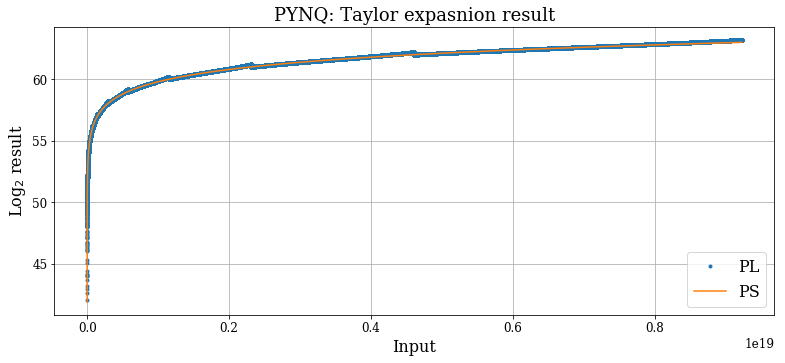

In [73]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(input_value    ,out_pl      , '.', label="PL")
plt.plot(input_value_sort,out_ps_sort, '-', label="PS")
plt.title('PYNQ: Taylor expasnion result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_TE_res", bbox_inches='tight')
#######################################################################

plt.show()

In [74]:
error_a = (out_ps-out_pl)
error_r = (out_ps-out_pl)/out_ps

### Relative error distribution

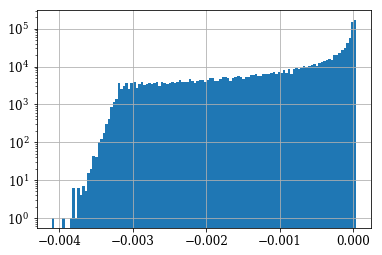

In [75]:
plt.hist(error_r,bins=120)
plt.semilogy()
plt.grid(True)
plt.show()

In [76]:
print("Mean relative error distribution               = %f " % np.mean(error_r))
print("Standard deviation relative error distribution = %f " % np.std(error_r))

Mean relative error distribution               = -0.000698 
Standard deviation relative error distribution = 0.000898 


### Absolute error distribution

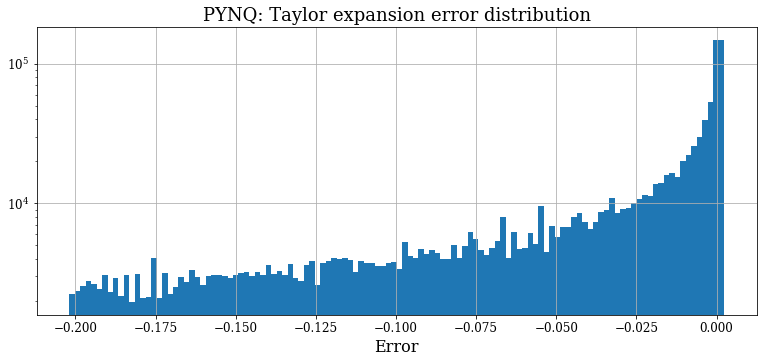

In [77]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)

#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(error_a,bins=120)
plt.title('PYNQ: Taylor expansion error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_TE_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

In [78]:
print("Mean absolute error distribution               = %f " % np.mean(error_a))
print("Standard deviation absolute error distribution = %f " % np.std(error_a))

Mean absolute error distribution               = -0.043163 
Standard deviation absolute error distribution = 0.055584 


## LUT 

In [79]:
time_pl_arr = []
for i in range(50):
    time_s=time.time()
    lut_dma.sendchannel.transfer(input_buffer)
    lut_dma.recvchannel.transfer(output_buffer)

    lut_dma.sendchannel.wait()
    lut_dma.recvchannel.wait()
    time_pl=time.time()-time_s
    time_pl_arr.append(time_pl)
time_pl = np.mean(time_pl_arr)
std_time_pl = np.std(time_pl_arr)
print(time_pl)

0.007191462516784668


In [80]:
#Conversion from fixed point to readable number
out_pl=output_buffer/(2**10)

In [81]:
time_ps_arr = []
for i in range(50):
    time_s=time.time()
    out_ps=np.log2(input_value)
    time_ps=time.time()-time_s
    time_ps_arr.append(time_ps)
time_ps = np.mean(time_ps_arr)
std_time_ps = np.std(time_ps_arr)
print(time_ps)

0.3725036859512329


In [82]:
print("%d input samples" % n)
print("PL computation time = %f+/-%f s" % (time_pl, std_time_pl))
print("PS computation time = %f+/-%f  s" % (time_ps, std_time_ps))
print("PL computation time per sample = %e+/-%e s" % (time_pl/n, std_time_pl/n))
print("PS computation time per sample = %e+/-%e s" % (time_ps/n, std_time_ps/n))
print("PL is %f times faster than the PS" % (time_ps/time_pl))

1048576 input samples
PL computation time = 0.007191+/-0.000149 s
PS computation time = 0.372504+/-0.000172  s
PL computation time per sample = 6.858313e-09+/-1.425085e-10 s
PS computation time per sample = 3.552472e-07+/-1.636161e-10 s
PL is 51.798043 times faster than the PS


In [83]:
input_value_sort = np.sort(input_value, kind='heapsort')
out_ps_sort      = np.sort(out_ps     , kind='heapsort')

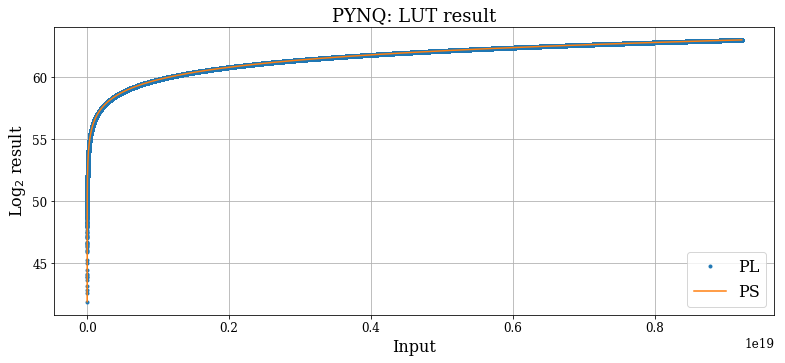

In [84]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(input_value    ,out_pl      , '.', label="PL")
plt.plot(input_value_sort,out_ps_sort, '-', label="PS")
plt.title('PYNQ: LUT result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_LUT_res", bbox_inches='tight')
#######################################################################

plt.show()

In [85]:
error_a = (out_ps-out_pl)
error_r = (out_ps-out_pl)/out_ps

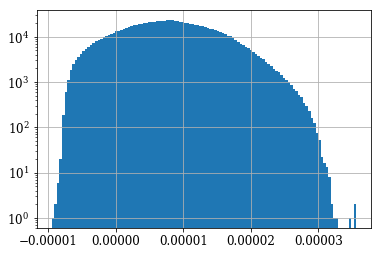

In [86]:
plt.hist(error_r,bins=120)
plt.semilogy()
plt.grid(True)
plt.show()

In [87]:
print("Mean relative error distribution               = %f " % np.mean(error_r))
print("Standard deviation relative error distribution = %f " % np.std(error_r))

Mean relative error distribution               = 0.000008 
Standard deviation relative error distribution = 0.000007 


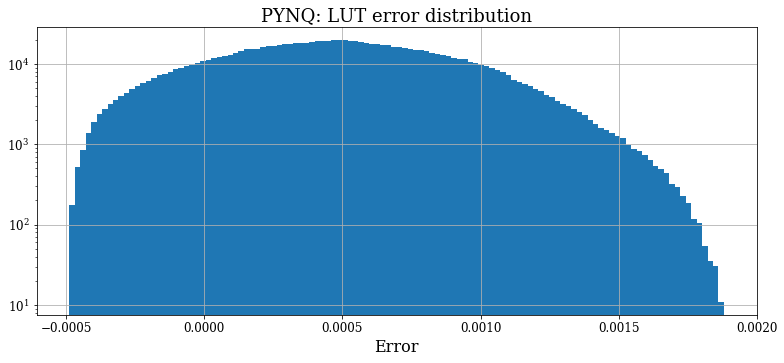

In [88]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)

#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(error_a,bins=120)
plt.title('PYNQ: LUT error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_LUT_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

In [89]:
print("Mean absolute error distribution               = %f " % np.mean(error_a))
print("Standard deviation absolute error distribution = %f " % np.std(error_a))

Mean absolute error distribution               = 0.000492 
Standard deviation absolute error distribution = 0.000412 


## Polyfit

In [90]:
time_pl_arr = []
for i in range(50):
    time_s=time.time()
    poly_dma.sendchannel.transfer(input_buffer)
    poly_dma.recvchannel.transfer(output_buffer)

    poly_dma.sendchannel.wait()
    poly_dma.recvchannel.wait()
    time_pl=time.time()-time_s
    time_pl_arr.append(time_pl)
time_pl = np.mean(time_pl_arr)
std_time_pl = np.std(time_pl_arr)
print(time_pl)

0.007213315963745117


In [91]:
#Conversion from fixed point to readable number
out_pl=output_buffer/(2**10)

In [92]:
time_ps_arr = []
for i in range(50):
    time_s=time.time()
    out_ps=np.log2(input_value)
    time_ps=time.time()-time_s
    time_ps_arr.append(time_ps)
time_ps = np.mean(time_ps_arr)
std_time_ps = np.std(time_ps_arr)
print(time_ps)

0.3636037874221802


In [93]:
print("%d input samples" % n)
print("PL computation time = %f+/-%f s" % (time_pl, std_time_pl))
print("PS computation time = %f+/-%f  s" % (time_ps, std_time_ps))
print("PL computation time per sample = %e+/-%e s" % (time_pl/n, std_time_pl/n))
print("PS computation time per sample = %e+/-%e s" % (time_ps/n, std_time_ps/n))
print("PL is %f times faster than the PS" % (time_ps/time_pl))

1048576 input samples
PL computation time = 0.007213+/-0.000456 s
PS computation time = 0.363604+/-0.000490  s
PL computation time per sample = 6.879154e-09+/-4.347889e-10 s
PS computation time per sample = 3.467596e-07+/-4.677665e-10 s
PL is 50.407301 times faster than the PS


In [94]:
input_value_sort = np.sort(input_value, kind='heapsort')
out_ps_sort      = np.sort(out_ps     , kind='heapsort')

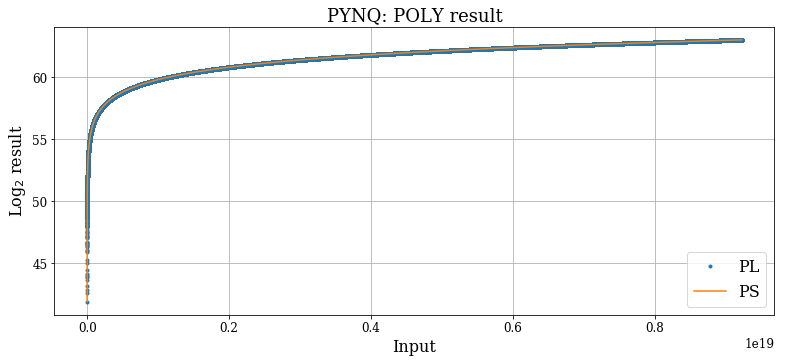

In [95]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)



#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))



plt.plot(input_value    ,out_pl      , '.', label="PL")
plt.plot(input_value_sort,out_ps_sort, '-', label="PS")
plt.title('PYNQ: POLY result')
plt.xlabel('Input')
plt.ylabel('Log$_2$ result')
plt.grid(True)
plt.legend()

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_POLY_res", bbox_inches='tight')
#######################################################################

plt.show()

In [96]:
error_a = (out_ps-out_pl)
error_r = (out_ps-out_pl)/out_ps

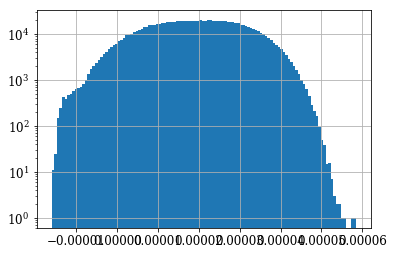

In [97]:
plt.hist(error_r,bins=120)
plt.semilogy()
plt.grid(True)
plt.show()

In [98]:
print("Mean relative error distribution               = %f " % np.mean(error_r))
print("Standard deviation relative error distribution = %f " % np.std(error_r))

Mean relative error distribution               = 0.000019 
Standard deviation relative error distribution = 0.000011 


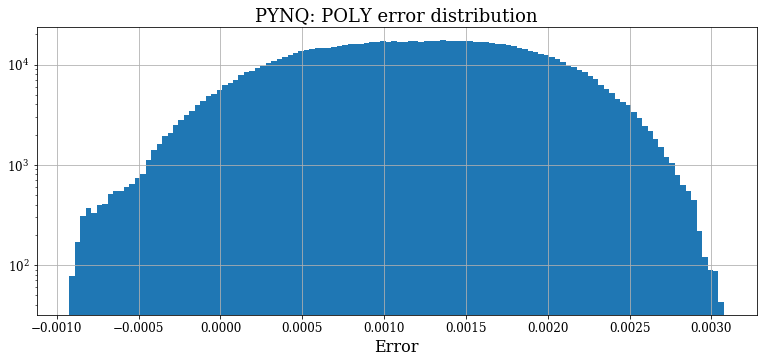

In [99]:
#######################################################################
# FIGURE
#######################################################################
fig = plt.figure(figsize=(10,4))
# plt.axes(axisbelow=True)

#######################################################################
##### TOP PANEL
#######################################################################
fig.add_axes((0.,0.35,1.0,1.0))

plt.hist(error_a,bins=120)
plt.title('PYNQ: POLY error distribution')
plt.xlabel('Error')
plt.semilogy()
plt.grid(True)

#######################################################################
##### SAVE FIGURE
#######################################################################
fig.savefig(SAVE_PATH + "PYNQ_POLY_LOG_error", bbox_inches='tight')
#######################################################################

plt.show()

In [100]:
print("Mean absolute error distribution               = %f " % np.mean(error_a))
print("Standard deviation absolute error distribution = %f " % np.std(error_a))

Mean absolute error distribution               = 0.001180 
Standard deviation absolute error distribution = 0.000701 
